This notebook is to help develop the rescaling experiments for sigma vs. baseline on SSD.

The initial goal is to take a trained SSD model and run the following evals on the TEST set. To start we'll work with COCO but it should work with any other dataset that is coco formatted. 

### Outline of Experiments:

- Create a pytorch transformation to rescale images
- Run eval on baseline (i.e., non-sigma SSD model) pretrained on normal image sizes
- Run eval on sigma version of same model
- Freeze free-form weights and fine tune the sigma scale layers (i think only the covariance regression layer, but should this also be the deformable conv layer? check with Evan or Dequan)


### Dev checklist (what we'll do in this notebook):
- [ ] Create a transform class to rescale the (images, bboxes, labels) 3-tuple
- [ ] Update ssd-master/ssd/data/transforms/\__init__.py: build_transforms() to allow training with rescaled images
- [ ] Update ssd-master/ssd/data/transforms/\__init__.py: build_transforms() to allow eval with rescaled images
- [ ] Update ssd-master/train.py to enable toggling rescaled training images via config file
- [ ] Update ssd-master/test.py to enable toggling rescaled test images via config file
- [ ] Run vanilla baseline
- [ ] Run sigma baseline w/o retraining
- [ ] Run sigma baseline with retraining (fine tuning only sigma layers)



In [1]:
# add h4d proj root to sys.path so we can import stuff that's in h4d_main/h4d:
# Example: suppose you want to import something from <h4d_main>/h4d/h4d/submodule/:
# "import h4d.submodule" or "from h4d.submodule import foo"
import sys, subprocess
from pathlib import Path
proj_root = Path(subprocess.check_output(['git','rev-parse','--show-toplevel']).strip().decode("utf-8"))
sys.path.append(str(proj_root))
sys.path.append(str(proj_root / "ssd-master"))

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

from typing import Dict, List
import cv2
from pycocotools.coco import COCO
import numpy as np
from PIL import Image, ImageDraw
import skimage.io as io
import matplotlib.pyplot as plt
import os.path
import pylab
pylab.rcParams['figure.figsize'] = (26.0, 26.0)

from ssd.data.datasets.coco import COCODataset

from h4dlib.config import h4dconfig


In [3]:
data_dir = h4dconfig.DATA_DIR / "coco"
data_split = "train2014"
annotations_dir, images_dir = data_dir / "annotations", data_dir / "images" / data_split
ann_file_train = annotations_dir / f"instances_{data_split}.json"
coco_train = COCO(ann_file_train)
print("data_dir: ", data_dir, "images_dir: ", images_dir)
print("annFile: ", ann_file_train)

tiny_coco_filename = annotations_dir / f"coco_tiny_test_train.json"
coco_tiny = COCO(tiny_coco_filename)

loading annotations into memory...
Done (t=9.97s)
creating index...
index created!
data_dir:  /home/gbiamby/school/h4d_main/h4d/datasets/coco images_dir:  /home/gbiamby/school/h4d_main/h4d/datasets/coco/images/train2014
annFile:  /home/gbiamby/school/h4d_main/h4d/datasets/coco/annotations/instances_train2014.json
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [4]:
# dir(coco_train)
img = coco_tiny.dataset["images"][0]
print(img)
img_anns = coco_tiny.imgToAnns[img["id"]]
print("Num annotations for img: ", len(img_anns))

{'license': 5, 'file_name': 'COCO_train2014_000000057870.jpg', 'coco_url': 'http://images.cocodataset.org/train2014/COCO_train2014_000000057870.jpg', 'height': 480, 'width': 640, 'date_captured': '2013-11-14 16:28:13', 'flickr_url': 'http://farm4.staticflickr.com/3153/2970773875_164f0c0b83_z.jpg', 'id': 57870}
Num annotations for img:  17


In [5]:
import torchvision.transforms as transforms
from ssd.transforms import *

In [6]:
# pytorch function to convert PIL images to tensors, and then the other way around:
pil2tensor = transforms.ToTensor()
tensor2pil = transforms.ToPILImage()


def plot_image(img_or_tensor):
    plt.figure()
    plt.axis('off')
    # imshow needs a numpy array with the channel dimension
    # as the the last dimension so we have to transpose things.
    if isinstance(img_or_tensor, np.ndarray):
        plt.imshow(img_or_tensor)
    else:
        plt.imshow(img_or_tensor.numpy().transpose(1, 2, 0))
    plt.show()


# Pulled these two functions from EPICHolo backend, they display an image with bounding boxes:
def show_img_bboxes(img: np.ndarray, boxes, labels) -> None:
    pil_image = Image.fromarray(img)
    pil_image_with_boxes = get_img_with_bboxes(pil_image, boxes)
    return pil_image_with_boxes
    
def get_img_with_bboxes(img: Image.Image, bboxes: List[List[float]]) -> Image.Image:
    """
    Draws 2d bounding boxes on a copy of the img that is passed in. 
    Args:
        img (Image.Image): image
        bboxes: dictionary of hololens frame capture metadata
    Returns:
        Pillow.Image.Image: Copy of img, with bounding rectangles drawn on it.
    """
    
    tmp_img = img.copy()
    draw = ImageDraw.Draw(tmp_img, 'RGBA')
    alpha = 95

    for i, box in enumerate(bboxes):
        # Pick random color:
        # Weird calculations b/c it's trying to encourage non-white (i.e., not all
        # channels close to same strength), and also tries encourages one channel to have
        # higher value than others (to lean towards R, G, or B):
        c = np.random.randint(low=40, high=156, size=4)
        strong_channel = np.random.randint(low=0, high=3)
        c[strong_channel] += 100
        c[3] = alpha

        # Draw box:
        rect = [(box[0], box[1]), (box[2], box[3])]
        draw.rectangle(rect, tuple(c))
        c[3] = 255

        # Draw two outlines w/o fill. Two so we get a 2px border:
        draw.rectangle(rect, fill=None, outline=tuple(c))
        rect = [(box[0]+1, box[1]+1)
                , (box[2]-1, box[3]-1)]
        draw.rectangle(rect, fill=None, outline=tuple(c))

    return tmp_img



image (tensor) size:  torch.Size([3, 480, 640])


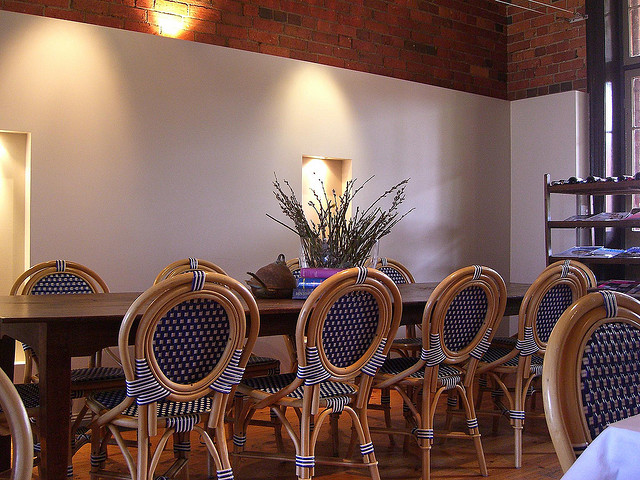

In [7]:
# Select an image from the COCO-formatted dataset to work with:

# Read the image from file. Assuming it is in the same directory.
pil_image = Image.open(images_dir / img["file_name"])
rgb_image = pil2tensor(pil_image)
print("image (tensor) size: ", rgb_image.size())
pil_image

In [8]:
rgb_image.size()
# img_anns

torch.Size([3, 480, 640])

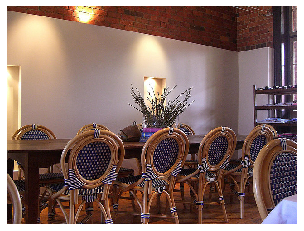

<class 'imageio.core.util.Array'>


In [9]:
I = io.imread(images_dir / img['file_name'])
plt.axis('off')
plt.imshow(I)
plt.show()
print(type(I))

Ann count:  17


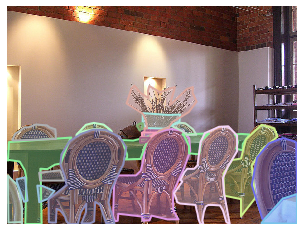

In [10]:
# load and display instance annotations (only for the specified cat_ids)
plt.imshow(I); plt.axis('off')
annIds = coco_tiny.getAnnIds(imgIds=img['id'], iscrowd=None)
anns = coco_tiny.loadAnns(annIds)
print("Ann count: ", len(anns))
coco_tiny.showAnns(anns)


In [11]:
# First take one of the existing transforms and try visualizing it on the coco images:
class Resize(object):
    def __init__(self, size=300):
        self.size = size

    def __call__(self, image, boxes=None, labels=None):
        image = cv2.resize(image, (self.size,
                                   self.size))
        return image, boxes, labels


In [12]:
coco_ds = COCODataset(images_dir, tiny_coco_filename, transform = None, target_transform=None)

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


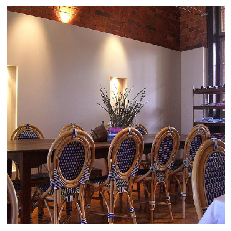

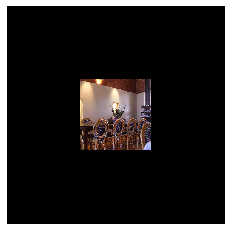

In [55]:
# Try resizing an image and then displaying:
img2 = coco_ds[0]


resize = Resize(size=350)
resized = resize(img2[0], img2[1], img2[2])
downsampled = shrinker(img2[0], img2[1]["boxes"], img2[1]["labels"])
plot_image(resized[0])
plot_image(downsampled[0])

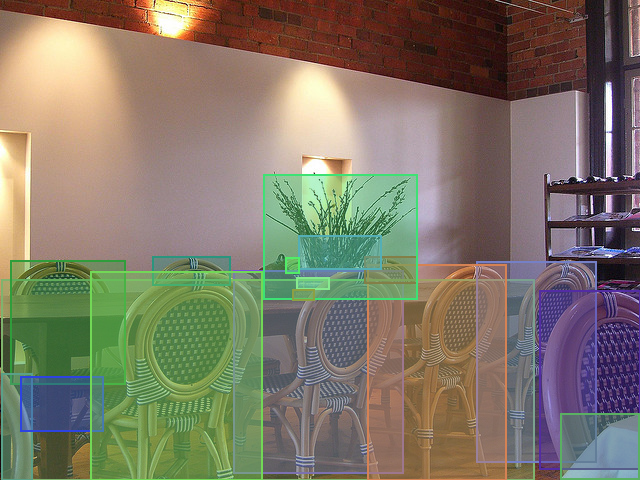

In [56]:

show_img_bboxes(img2[0], img2[1]["boxes"], None)


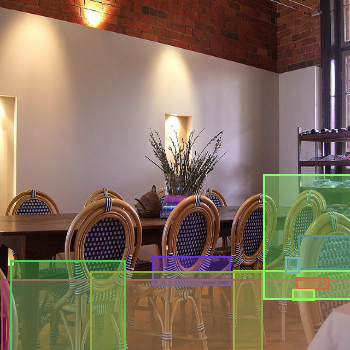

In [57]:
# The bboxes look messed up in this version, that's expected b/c 
show_img_bboxes(resized[0], resized[1]["boxes"], None)

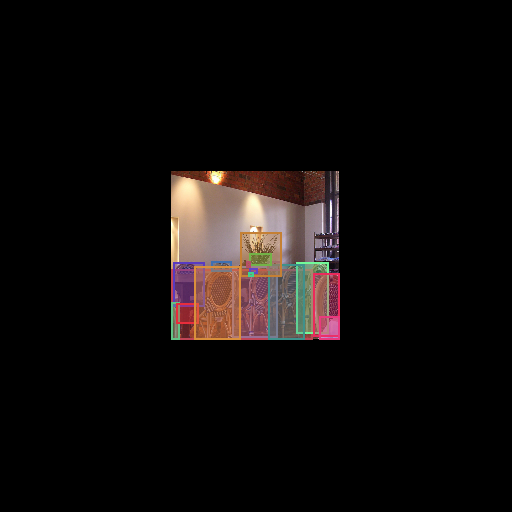

In [59]:

show_img_bboxes(downsampled[0], downsampled[1], downsampled[2])

In [42]:
class ShrinkAndPad(object):
    """
    Image is first downsampled by rescale_factor (and converted to square aspect ratio in the process),
    and then padding is added to make the final outputted image size be image_size.
    """
    def __init__(self, image_size, rescale_factor=0.5, mean = 0):
        self.rescale_factor = rescale_factor
        self.image_size = image_size
        self.mean = mean

    def __call__(self, image, boxes=None, labels=None):
        # Downsample:
        downsampled_size = float(self.image_size * self.rescale_factor)
        img_size = image.shape[:2]
        height_ratio, width_ratio = downsampled_size / img_size[0], downsampled_size / img_size[1]
        boxes = boxes.copy()
        boxes[:,[0,2]] = boxes[:,[0,2]] * width_ratio
        boxes[:,[1,3]] = boxes[:,[1,3]] * height_ratio
        downsampled_image = cv2.resize(image, (int(downsampled_size), int(downsampled_size)))
        
        # Pad up to larger size:
        left = int((self.image_size - downsampled_size) / 2.0)
        top = left #img is square at this point, so top==left
        expand_image = np.zeros((self.image_size, self.image_size, depth), dtype=image.dtype)
        expand_image[:, :, :] = self.mean
        expand_image[top:(top + int(downsampled_size)),left:(left + int(downsampled_size))] = downsampled_image
        image = expand_image
        boxes += left
        return image, boxes, labels


image_size:  512 rescale_factor:  0.9 rescaled_size:  460


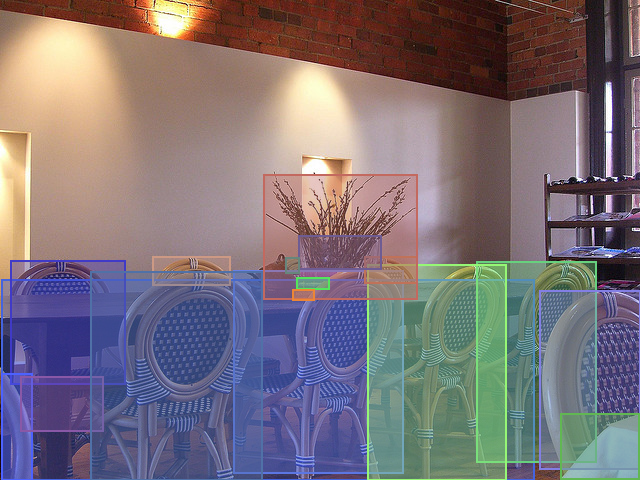

In [67]:
image_size = 512
rescale_factor = 0.9
rescaled_image_size = int(image_size * rescale_factor)
print("image_size: ", image_size, "rescale_factor: ", rescale_factor, "rescaled_size: ", rescaled_image_size)
shrinker = ShrinkAndPad(image_size=image_size, rescale_factor=rescale_factor)

# resized = resize(img2[0], img2[1], img2[2])
rescaled = shrinker(img2[0], img2[1]["boxes"], img2[1]["labels"])
show_img_bboxes(img2[0], img2[1]["boxes"], img2[1]["labels"])

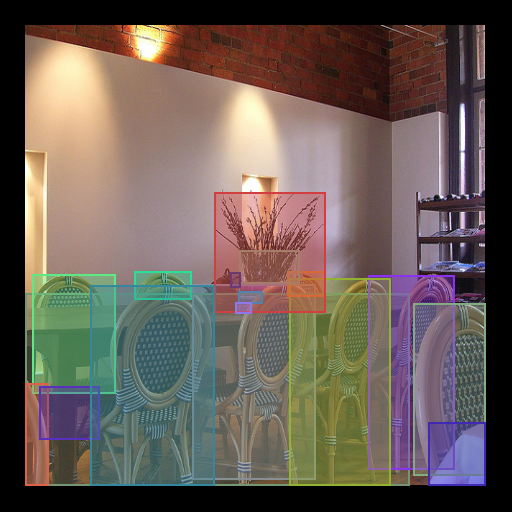

In [68]:
show_img_bboxes(rescaled[0], rescaled[1], rescaled[2])

In [112]:
img2[1]["boxes"]

array([[233.29, 270.45, 403.61, 473.81],
       [  1.02, 279.96, 534.11, 480.  ],
       [476.76, 261.03, 596.49, 462.74],
       [ 10.79, 260.03, 125.12, 384.07],
       [367.82, 264.27, 506.97, 480.  ],
       [539.33, 290.16, 640.  , 469.21],
       [364.4 , 256.57, 417.06, 283.21],
       [152.17, 256.67, 230.58, 285.78],
       [  1.08, 373.21,  32.36, 480.  ],
       [298.2 , 235.17, 381.21, 269.25],
       [285.8 , 257.46, 299.77, 273.6 ],
       [ 20.54, 376.76, 103.78, 431.89],
       [263.03, 174.37, 417.67, 299.4 ],
       [560.8 , 413.95, 639.09, 479.2 ],
       [296.78, 277.79, 329.26, 289.78],
       [292.8 , 289.31, 314.21, 300.65],
       [ 90.67, 271.49, 262.51, 480.  ]], dtype=float32)

In [34]:
# Setup fake params:
image = img2[0].copy()
boxes = img2[1]["boxes"].copy()
rescale_factor = 0.6
image_size = 512
mean = 0

# Prototype Code:
downsampled_size = float(image_size * rescale_factor)
img_size = img2[0].shape[:2]
height, width, depth = image.shape
height_ratio, width_ratio = downsampled_size / height, downsampled_size / width
print("width: ", width_ratio, ", height: ", height_ratio)

downsampled_image = cv2.resize(image, (int(downsampled_size), int(downsampled_size)))
print(boxes)
boxes[:,[0,2]] = boxes[:,[0,2]] * width_ratio
boxes[:,[1,3]] = boxes[:,[1,3]] * height_ratio
print(boxes)


left = int((image_size - downsampled_size) / 2.0)
top = left #img is square at this point, so top==left

expand_image = np.zeros((image_size, image_size, depth), dtype=image.dtype)
expand_image[:, :, :] = mean
expand_image[top:(top + int(downsampled_size)),left:(left + int(downsampled_size))] = downsampled_image
image = expand_image

boxes += left

width:  0.48 , height:  0.64
[[233.29 270.45 403.61 473.81]
 [  1.02 279.96 534.11 480.  ]
 [476.76 261.03 596.49 462.74]
 [ 10.79 260.03 125.12 384.07]
 [367.82 264.27 506.97 480.  ]
 [539.33 290.16 640.   469.21]
 [364.4  256.57 417.06 283.21]
 [152.17 256.67 230.58 285.78]
 [  1.08 373.21  32.36 480.  ]
 [298.2  235.17 381.21 269.25]
 [285.8  257.46 299.77 273.6 ]
 [ 20.54 376.76 103.78 431.89]
 [263.03 174.37 417.67 299.4 ]
 [560.8  413.95 639.09 479.2 ]
 [296.78 277.79 329.26 289.78]
 [292.8  289.31 314.21 300.65]
 [ 90.67 271.49 262.51 480.  ]]
[[111.979195   173.088      193.73279    303.2384    ]
 [  0.48959997 179.1744     256.37277    307.19998   ]
 [228.8448     167.05919    286.3152     296.1536    ]
 [  5.1791997  166.41919     60.0576     245.8048    ]
 [176.5536     169.13278    243.3456     307.19998   ]
 [258.8784     185.7024     307.19998    300.2944    ]
 [174.91199    164.2048     200.1888     181.2544    ]
 [ 73.041595   164.2688     110.6784     182.8992    ]
 [ 